In [27]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from pandas.tseries.offsets import MonthEnd

import matplotlib.pyplot as plt

In [28]:
# Load Individual Model Predictions
yoy_preds = pd.read_csv('YoY_Model_Preds.csv').set_index('date').iloc[:,1:]
mom_preds = pd.read_csv('Sequential_Model_Preds.csv').set_index('date').iloc[:,1:]

# Load Actual Intermodal RPU
file_path = Path("Quarterly Input Data.xlsx")
rpu_df = pd.read_excel(file_path).set_index('date')[::-1]

rpu_df.index = rpu_df.index.astype(str)

rpu_yoy_comps = rpu_df.shift(4)
rpu_yoy_df = (rpu_df / rpu_yoy_comps - 1).dropna()

In [29]:
mom_to_yoy_forecasts = pd.DataFrame(columns = rpu_df.columns)
for ticker in rpu_df.columns:
    print(ticker)
    column = []
    dates_list = []
    for i, forecast in enumerate(mom_preds[ticker]):
        
        date = mom_preds[ticker].index[i]
        dates_list.append(str(date))
        prev_date = datetime.strptime(date, '%Y-%m-%d') - MonthEnd(3)
        prev_date = prev_date.strftime('%Y-%m-%d')
        tmp = rpu_df.loc[prev_date][ticker] * (1+forecast)
        #tmp = pd.DataFrame([tmp])
        #tmp.columns = [ticker]
        column.append(tmp)
        #mom_to_yoy_forecasts = pd.concat([mom_to_yoy_forecasts, tmp])
    mom_to_yoy_forecasts[ticker] = column

mom_to_yoy_forecasts['date'] = dates_list
mom_to_yoy_forecasts = mom_to_yoy_forecasts.set_index('date')

JBHT
NSC
CSX
UNP


In [30]:
    
#mom_to_yoy_forecasts.columns = mom_preds.columns
mom_to_yoy_forecasts = ((mom_to_yoy_forecasts - rpu_yoy_comps)/rpu_yoy_comps).dropna()

# M/M forecast error
((mom_to_yoy_forecasts - rpu_yoy_df)**2).mean()**0.5

JBHT    0.028219
NSC     0.020762
CSX     0.016460
UNP     0.028514
dtype: float64

In [31]:
# Y/Y forecast error
((yoy_preds - rpu_yoy_df)**2).mean()**0.5

JBHT    0.029103
NSC     0.030195
CSX     0.027085
UNP     0.036805
dtype: float64

In [32]:
# Ensemble forecast error
ensemble_preds = 0.4*yoy_preds + 0.6*mom_to_yoy_forecasts
((ensemble_preds - rpu_yoy_df)**2).mean()**0.5

JBHT    0.024155
NSC     0.022655
CSX     0.018708
UNP     0.028453
dtype: float64

In [34]:
rpu_yoy_df.corr()

,JBHT,NSC,CSX,UNP
JBHT,1.000000,0.912097,0.734743,0.756256
NSC,0.912097,1.000000,0.785284,0.828350
CSX,0.734743,0.785284,1.000000,0.647559
UNP,0.756256,0.828350,0.647559,1.000000


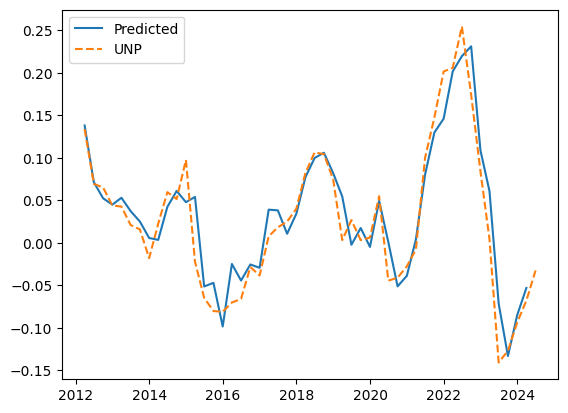

In [35]:
y_test_df = rpu_yoy_df[rpu_yoy_df.index >= ensemble_preds.index[0]]

ticker = 'UNP'
plt.plot(pd.to_datetime(ensemble_preds.index), ensemble_preds[ticker], label='Predicted')
plt.plot(pd.to_datetime(y_test_df.index), y_test_df[ticker], label=ticker, linestyle='--')
plt.legend()
plt.show()

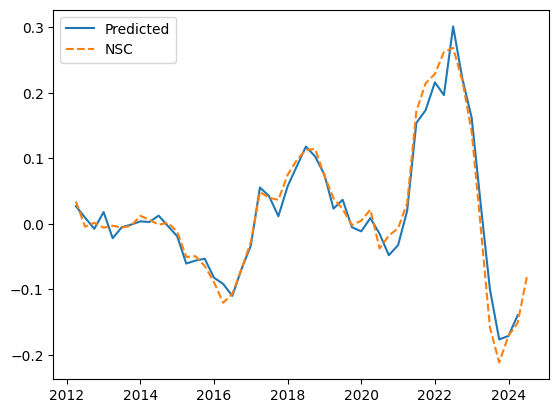

In [37]:
y_test_df = rpu_yoy_df[rpu_yoy_df.index >= mom_to_yoy_forecasts.index[0]]

ticker = 'NSC'
plt.plot(pd.to_datetime(mom_to_yoy_forecasts.index), mom_to_yoy_forecasts[ticker], label='Predicted')
plt.plot(pd.to_datetime(y_test_df.index), y_test_df[ticker], label=ticker, linestyle='--')
plt.legend()
plt.show()